### Imports

In [1]:
import pandas as pd
import numpy as np
import pickle as pk
import requests
import copy
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LinearRegression

### Data collection

In [2]:
df = pd.read_parquet("df_all_features.pq")

In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMRanker  

# ==========================================
# 1. DATA PREPARATION FOR LISTWISE RANKING (CORRECTED)
# ==========================================

# 1.1 Sort Data by Date
# LightGBM requires query data (groups) to be contiguous. 
# Since 'Date' is your index, we sort by index.
df = df.sort_index() 

# 1.2 Define Feature Columns
# We must exclude metadata (Ticker), targets (returns), and intermediate columns.
features_to_drop = ['Ticker', 'close_1d_ret', 'relevance', 'predicted_score']
# Note: 'Date' is in the index, so we don't need to drop it from columns
feature_cols = [c for c in df.columns if c not in features_to_drop]

print(f"Feature selection complete. Number of features: {len(feature_cols)}")

# 1.3 Create 'Relevance' Target (The Fix for rank_xendcg)
# PROBLEM: The 'rank_xendcg' objective treats the target as a discrete "grade" (like stars 0-5).
# LightGBM has a hard limit (usually 31 bins) for these grades.
# Passing raw ranks (e.g., 1 to 135) caused the "Label 135 is not less than..." error.

# SOLUTION: Normalize returns to a 0-30 integer scale.
# - pct=True: Converts ranks to percentiles (0.0 to 1.0)
# - * 30: Scales to 0.0 to 30.0
# - astype(int): Converts to integers (0, 1, ..., 30)
# Result: 0 = Worst asset of the day, 30 = Best asset of the day.
df['relevance'] = df.groupby(level=0)['close_1d_ret'].transform(
    lambda x: (x.rank(pct=True) * 30).clip(0, 30).astype(int)
)

# 1.4 Construct X (Features) and y (Target)
X = df[feature_cols]
y = df['relevance']

# 1.5 Create Query Groups
# This array tells LightGBM the size of each "query" (each day).
# Example: [100, 102, 98...] means Day 1 has 100 rows, Day 2 has 102, etc.
# We use level=0 because grouping is done on the Index (Date).
groups = df.groupby(level=0).size().to_numpy()

# Verification
print(f"Data shapes: X={X.shape}, y={y.shape}")
print(f"Number of groups (days): {len(groups)}")
print(f"Relevance range: Min={y.min()}, Max={y.max()} (Should be 0 to 30)")

Feature selection complete. Number of features: 230
Data shapes: X=(2760451, 230), y=(2760451,)
Number of groups (days): 6513
Relevance range: Min=0, Max=30 (Should be 0 to 30)


In [4]:
# ==========================================
# 2. TIME-SERIES SPLIT (TRAIN / TEST)
# ==========================================

# We split by GROUPS (Days), not by rows, to avoid data leakage
train_ratio = 0.80
split_group_idx = int(len(groups) * train_ratio)

# Calculate the row index corresponding to the group split
split_row_idx = sum(groups[:split_group_idx])

# Split datasets
X_train, X_test = X.iloc[:split_row_idx], X.iloc[split_row_idx:]
y_train, y_test = y.iloc[:split_row_idx], y.iloc[split_row_idx:]
groups_train = groups[:split_group_idx]
groups_test = groups[split_group_idx:]

# Keep original returns and dates for financial evaluation later
returns_test = df['close_1d_ret'].iloc[split_row_idx:]
# FIX: Retrieve dates from the index, not a column
dates_test = df.index[split_row_idx:]

print(f"Train set: {len(X_train)} rows ({len(groups_train)} days)")
print(f"Test set:  {len(X_test)} rows ({len(groups_test)} days)")

Train set: 2133113 rows (5210 days)
Test set:  627338 rows (1303 days)


In [5]:
# ==========================================
# 3. DEFINE AND TRAIN MODEL (LISTWISE)
# ==========================================

model = LGBMRanker(
    objective="rank_xendcg",    # Listwise objective (Cross-Entropy NDCG)
    metric="ndcg",              # Evaluation metric
    boosting_type="gbdt",
    n_estimators=150,           # Number of trees
    learning_rate=0.05,
    num_leaves=31,
    max_depth=6,                # Prevent overfitting
    random_state=42,
    n_jobs=-1                   # Use all CPU cores
)

print("\nStarting training... (This might take a few minutes)")

# Callbacks for early stopping and logging
# Updated API for LightGBM 4.0+
callbacks = [
    lgb.early_stopping(stopping_rounds=20),
    lgb.log_evaluation(period=20)
]

model.fit(
    X_train, 
    y_train, 
    group=groups_train,
    eval_set=[(X_test, y_test)],
    eval_group=[groups_test],
    eval_at=[5, 10],            # Check NDCG@5 and NDCG@10
    callbacks=callbacks
)


Starting training... (This might take a few minutes)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.425699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58650
[LightGBM] [Info] Number of data points in the train set: 2133113, number of used features: 230
Training until validation scores don't improve for 20 rounds
[20]	valid_0's ndcg@5: 0.959662	valid_0's ndcg@10: 0.969697
[40]	valid_0's ndcg@5: 0.964828	valid_0's ndcg@10: 0.973814
[60]	valid_0's ndcg@5: 0.967431	valid_0's ndcg@10: 0.975823
Early stopping, best iteration is:
[59]	valid_0's ndcg@5: 0.967617	valid_0's ndcg@10: 0.975995


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,6
,learning_rate,0.05
,n_estimators,150
,subsample_for_bin,200000
,objective,'rank_xendcg'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20



Predicting scores on Test Set...


/opt/python/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:54: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/opt/python/lib/python3.13/site-packages/matplotlib/ticker.py:2178: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


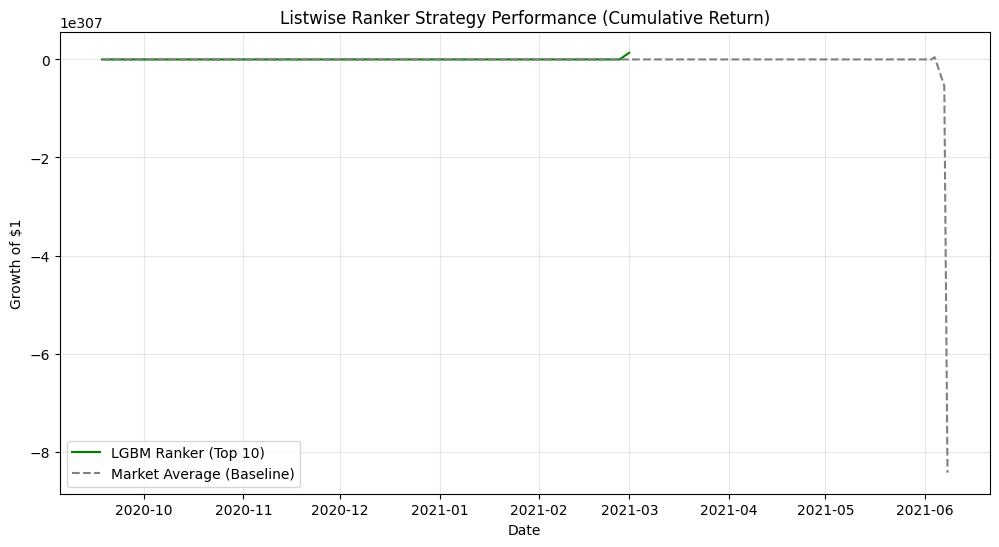

Strategy Sharpe Ratio: 36.61


In [6]:
# ==========================================
# 4. EVALUATION (FINANCIAL METRICS)
# ==========================================

print("\nPredicting scores on Test Set...")
# Predict ranking scores (higher score = buy signal)
predictions = model.predict(X_test)

# Create a results DataFrame
df_results = pd.DataFrame({
    'Actual_Return': returns_test.values,
    'Predicted_Score': predictions
}, index=dates_test) # Set index directly

# Define a simple Long-Only Strategy: Buy Top K assets per day
def evaluate_top_k_strategy(data, k=10):
    # Select top K assets with highest predicted scores
    top_k = data.nlargest(k, 'Predicted_Score')
    # Return the average return of these K assets
    return top_k['Actual_Return'].mean()

# Calculate daily strategy returns
# Grouping by level=0 (Date index)
strategy_daily_returns = df_results.groupby(level=0).apply(lambda x: evaluate_top_k_strategy(x, k=10))

# Calculate cumulative returns
cumulative_strategy = (strategy_daily_returns + 1).cumprod()

# Baseline: Mean return of all assets available in the test set
# Grouping by level=0 (Date index)
cumulative_market = (returns_test.groupby(level=0).mean() + 1).cumprod()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(cumulative_strategy, label='LGBM Ranker (Top 10)', color='green')
plt.plot(cumulative_market, label='Market Average (Baseline)', color='gray', linestyle='--')
plt.title('Listwise Ranker Strategy Performance (Cumulative Return)')
plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print Statistics
sharpe = strategy_daily_returns.mean() / strategy_daily_returns.std() * np.sqrt(252)
print(f"Strategy Sharpe Ratio: {sharpe:.2f}")